<a href="https://colab.research.google.com/github/hwangzie/Detect-Corner-Mark-on-Device-and-Image-Quality/blob/main/Corner_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os

In [4]:
# load the dir for labeling
data_dir = '/content/drive/MyDrive/Dataset_NBS'
dataset =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    class_names=['false', 'true'],
    batch_size=16,
    image_size=(224, 224),
    shuffle=True
)
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

Found 240 files belonging to 2 classes.


Labels: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]]


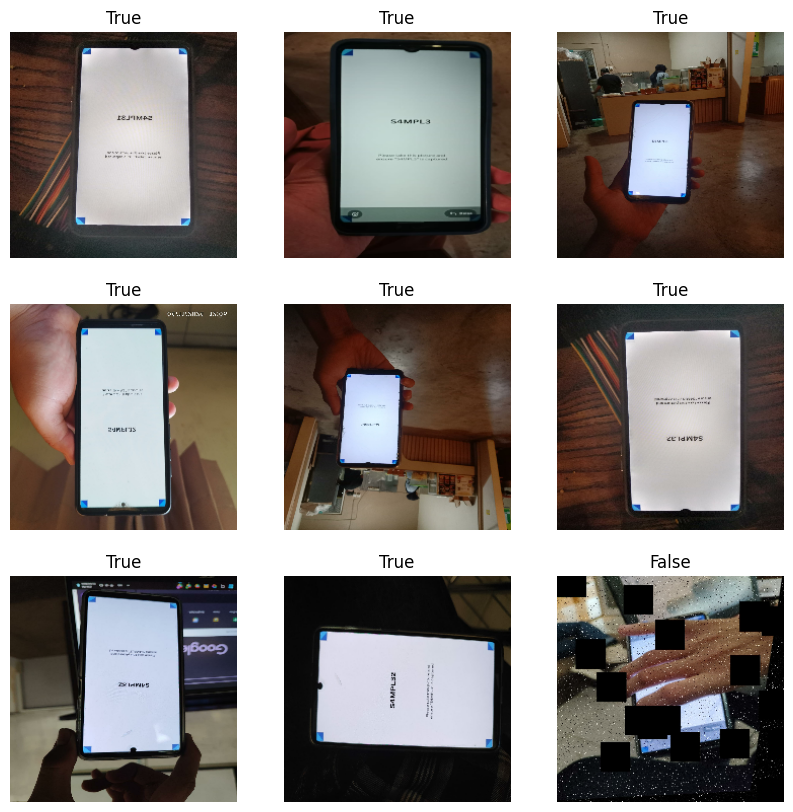

In [5]:
# Display one batch of images and labels
for images, labels in dataset.take(1):  # Take a single batch
    print("Labels:", labels.numpy())    # Print labels (0 or 1 for binary)

    # Plot the images
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # Access the probability for the 'True' class (assuming it's the first class)
        # and display 'True' if it's greater than 0.5, otherwise 'False'
        plt.title("False" if labels[i][0] < 0.5 else "True")
        plt.axis("off")
    plt.show()

In [9]:
# base_model = tf.keras.applications.MobileNetV3Small(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet'
# )

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
)

base_model.trainable = False
layer_index = None
# for i, layer in enumerate(base_model.layers):
#     if layer.name == 'block_6_project_BN':
#         layer_index = i
#         break
# if layer_index is not None:
#     base_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[layer_index].output)
#     base_model.trainable = False


In [16]:
model = tf.keras.models.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# callback if model reach 89 accuracy
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 89% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()


In [18]:
# Import necessary libraries
from IPython.display import clear_output
import gc
import tensorflow as tf
# Clear all variables and garbage collect
gc.collect()
# Reset TensorFlow session to release memory
tf.keras.backend.clear_session()
# Clear the output in Colab
clear_output()

In [19]:
history = model.fit(dataset, epochs=50, callbacks=[callbacks])

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.7605 - loss: 12.5508
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - accuracy: 0.7151 - loss: 11.8182
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step - accuracy: 0.7284 - loss: 11.1382
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.7375 - loss: 10.5252
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.8002 - loss: 9.8806
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - accuracy: 0.8108 - loss: 9.2675
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step - accuracy: 0.8304 - loss: 8.7540
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - accuracy: 0.8351 - loss: 8.2433
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - accuracy: 0.8141 - loss: 7.7753
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - accuracy: 0.8110 - loss: 7.3332
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.8172 - loss: 6.9222
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 352ms

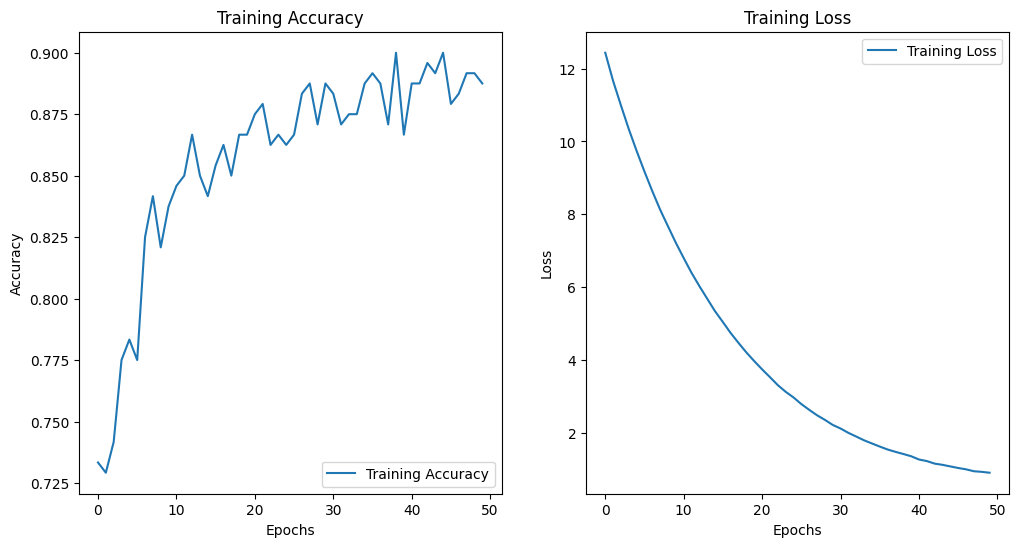

In [20]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend(loc='lower right')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend(loc='upper right')
    plt.show()
plot_training_history(history)

In [21]:
import shutil

shutil.make_archive('model', 'zip', 'model')

from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction score: [1.0341651]


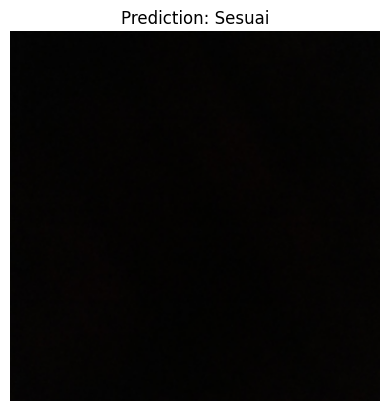

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction score: [0.5497581]


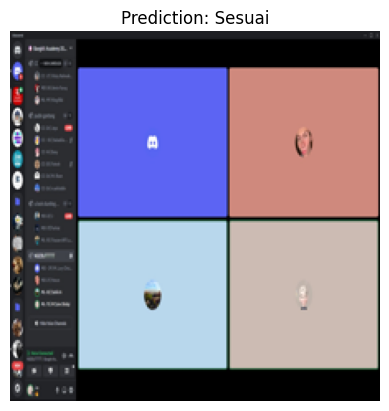

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction score: [0.79974663]


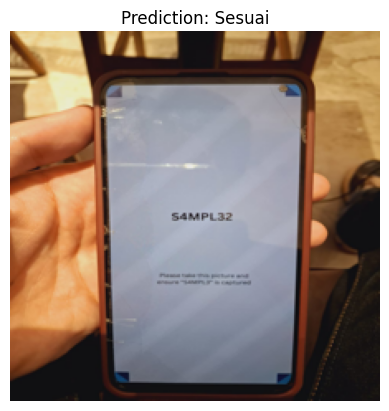

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction score: [0.75334966]


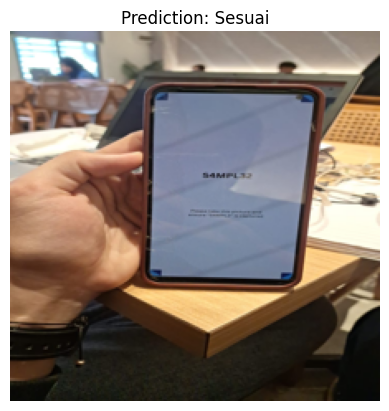

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction score: [0.8838035]


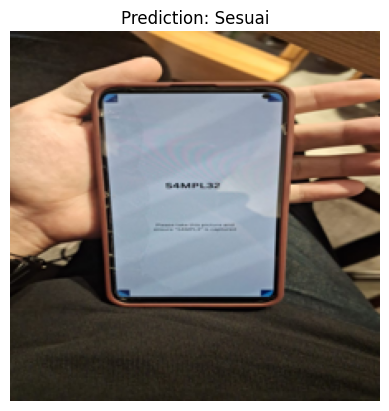

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction score: [0.21631187]


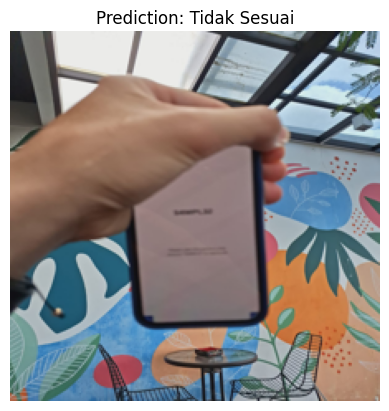

Prediction result: Tidak Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction score: [0.4593656]


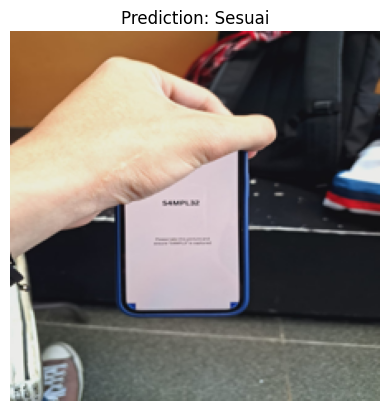

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction score: [0.3308668]


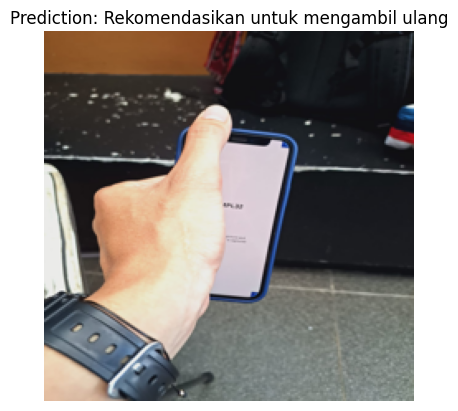

Prediction result: Rekomendasikan untuk mengambil ulang
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction score: [0.7437289]


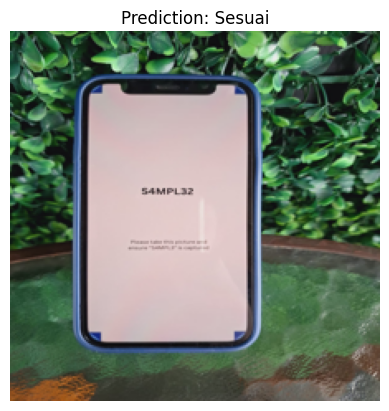

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction score: [0.9330624]


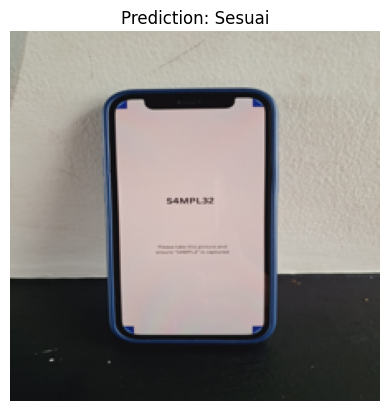

Prediction result: Sesuai


In [23]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from io import BytesIO
import ipywidgets as widgets
from IPython.display import display

upload_button = widgets.FileUpload(accept='image/*', multiple=True)
display(upload_button)

def predict_uploaded_image(model, uploaded_file):
    img = Image.open(BytesIO(uploaded_file['content']))
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    if prediction[0] > 0.4:
        result = "Sesuai"
        print(f"Prediction score: {prediction[0]}")

    elif prediction[0] > 0.32:
        result = "Rekomendasikan untuk mengambil ulang"
        print(f"Prediction score: {prediction[0]}")

    else:
        result = "Tidak Sesuai"
        print(f"Prediction score: {prediction[0]}")

    plt.imshow(img)
    plt.title(f"Prediction: {result}")
    plt.axis('off')
    plt.show()

    print(f"Prediction result: {result}")
    return result

def on_upload_change(change):
    for uploaded_file in upload_button.value.values():
        # print(f"Processing file: {uploaded_file['name']}")
        predict_uploaded_image(model, uploaded_file)

upload_button.observe(on_upload_change, names='value')


In [24]:
import tensorflow as tf

import pathlib
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

## Convert the SavedModel to TFLite

In [29]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# dowload
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpbg36zj6p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133509599713536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133509598231920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133509598228928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133509598226464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133509598227520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133509598225760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133509598228576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133509598229456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133512503556608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133510065408128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13350959822963

In [27]:
tflite_model_file = pathlib.Path('final_model.tflite')
# tflite_model_file.write_bytes(tflite_model_file)

## Initialize the TFLite interpreter to try it out

In [28]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model_file.read_bytes())
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

FileNotFoundError: [Errno 2] No such file or directory: 'final_model.tflite'

In [ ]:
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import numpy as np
import io
import matplotlib.pyplot as plt

# Create an upload button
upload_button = widgets.FileUpload(accept='image/*', multiple=True)  # Allow multiple files
display(upload_button)

def predict_uploaded_image(model, interpreter, input_details, output_details, uploaded_file):
  """Predicts the class of an uploaded image using both TensorFlow and TensorFlow Lite."""

  # Preprocess the image
  img = Image.open(io.BytesIO(uploaded_file['content']))
  img = img.resize((224, 224))
  img_array = np.array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

  # TensorFlow Lite prediction
  interpreter.set_tensor(input_details[0]['index'], img_array)
  interpreter.invoke()
  tflite_results = interpreter.get_tensor(output_details[0]['index'])

  # TensorFlow prediction
  tf_results = model(tf.constant(img_array))
  output_data = np.array(tf_results)

  # Display results and image in a subplot
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  ax.imshow(img)
  ax.set_title(f"TF Lite: {tflite_results[0][0]}, TF: {output_data[0][0]}")
  ax.axis('off')
  plt.show()


def on_upload_change(change):
  """Handles the upload button change event."""
  for uploaded_file in upload_button.value.values():
    predict_uploaded_image(model, interpreter, input_details, output_details, uploaded_file)

# Observe the upload button for changes
upload_button.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

NameError: name 'model' is not defined

## Visualize the model

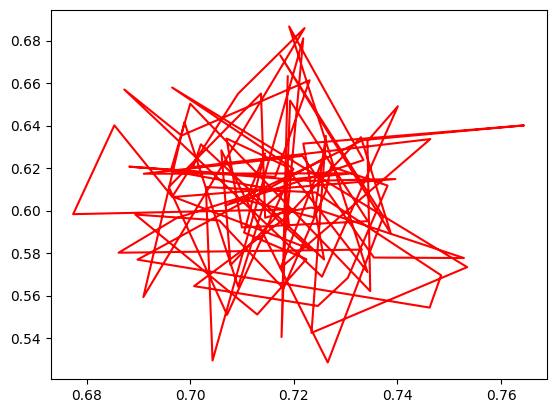

In [ ]:
plt.plot(inputs, outputs, 'r')
plt.show()

## Download the TFLite model file

In [ ]:
try:
  from google.colab import files
  files.download(tflite_model_file)
except:
  pass

In [ ]:
!pip install tflite-support

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 51.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np

def create_tflite_metadata(
    model_path,
    input_shape=(1, 224, 224, 3),
    input_name='input',
    output_name='output',
    labels=None
):
    """
    Create TensorFlow Lite model metadata

    Args:
        model_path (str): Path to save the TFLite model with metadata
        input_shape (tuple): Shape of input tensor (default is for image classification)
        input_name (str): Name of the input tensor
        output_name (str): Name of the output tensor
        labels (list): Optional list of class labels

    Returns:
        Metadata-enhanced TFLite model path
    """
    # Import metadata writer
    from tflite_support import metadata_schema_py_generated as _metadata_fb
    from tflite_support import metadata as _metadata

    # Create metadata writer
    model_metadata = _metadata.ModelMetadataBuilder()

    # Create input metadata
    input_md = _metadata.TensorMetadataBuilder()
    input_md.name(input_name)
    input_md.description("Input image for classification")

    # Add normalization metadata
    input_md.stats(_metadata_fb.StatsT().Stats(
        max=[1.0],
        min=[0.0]
    ))

    # Create output metadata
    output_md = _metadata.TensorMetadataBuilder()
    output_md.name(output_name)
    output_md.description("Classification probabilities")

    # Add labels if provided
    if labels:
        label_file = _metadata.LabelFileMetadataBuilder()
        label_file.name("labels.txt")
        label_file.description("Class labels")
        # Create label file
        with open("labels.txt", "w") as f:
            for label in labels:
                f.write(f"{label}\n")

        output_md.associated_files([label_file])

    # Add input and output metadata to model metadata
    model_metadata.name("Image Classification Model")
    model_metadata.description("TensorFlow Lite model for image classification")
    model_metadata.input_tensor_metadata(input_md)
    model_metadata.output_tensor_metadata(output_md)

    # Write metadata to the model
    output_model_path = model_path.replace('.tflite', '_with_metadata.tflite')

    # Use TFLite metadata writer
    writer = _metadata.MetadataWriter.create_from_file(
        model_path,
        input_metadata=input_md,
        output_metadata=output_md
    )

    # Write the metadata
    writer.populate_metadata_buffer()
    writer.write_metadata_file(output_model_path)

    return output_model_path

# Example usage
def main():
    # Sample usage
    model_path = 'final_model.tflite'
    labels = ['tidak sesuai', 'sesuai']  # Example class labels

    metadata_model_path = create_tflite_metadata(
        model_path,
        labels=labels
    )

    print(f"Model with metadata saved to: {metadata_model_path}")

if __name__ == '__main__':
    main()

ImportError: generic_type: cannot initialize type "StatusCode": an object with that name is already defined